## 📦  Imports

In [ ]:
import torch
from torch.utils.data import Dataset
import os
import cv2
import json
import numpy as np
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt

## 📖  Tratamento Dataset

In [58]:
class CustomHandToolKeypointDataset(Dataset):
    def __init__(self, images_root, annotation_root, transform=None):
        self.image_root = images_root
        self.annotation_root = annotation_root
        self.image_files = []
        self.annotation_files = []
        self.transform = transform

        for folder in os.listdir(images_root):
            folder_path = os.path.join(images_root, folder)
            if not os.path.isdir(folder_path):
                continue

            for fname in os.listdir(folder_path):
                if not fname.endswith(".jpg") and not fname.endswith(".png"):
                    continue

                image_path = os.path.join(folder_path, fname)
                ann_path = os.path.join(annotation_root, folder, os.path.splitext(fname)[0] + ".json")

                if os.path.exists(ann_path):
                    self.image_files.append(image_path)
                    self.annotation_files.append(ann_path)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        ann_path = self.annotation_files[idx]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        with open(ann_path) as f:
            ann = json.load(f)

        label_map = {
            "Hand": 1,
            "Scissors": 2,
            "Tweezers": 3,
            "Needle_Holder": 4,
            "Needle": 5
        }

        keypoints = []
        boxes = []
        labels = []

        # Process hands
        for hand in ann["hands"]:
            kpts = []
            for part in ["Thumb", "Index", "Middle", "Ring", "Pinky", "Back of hand"]:
                pt = hand["keypoints"].get(part, {"x": 0, "y": 0, "visibility": 0})
                kpts.append([pt["x"], pt["y"], pt["visibility"]])
            

            # bounding box com base nos keypoints visíveis
            visible = [kp[:2] for kp in kpts if kp[2] > 0]
            if len(visible) < 2:
                continue
            
            if visible:
                visible_np = np.array(visible)
                x_min, y_min = visible_np.min(axis=0)
                x_max, y_max = visible_np.max(axis=0)

                if x_max > x_min and y_max > y_min:
                    boxes.append([x_min, y_min, x_max, y_max])
                    keypoints.append(kpts)
                    labels.append(label_map["Hand"])  # classe 1 = mão

        # Processar ferramentas
        for tool in ann.get("tools", []):
            kpts = []
            for part in tool.get("keypoints", {}).values():
                kpts.append([part["x"], part["y"], part["visibility"]])
        
            if len(kpts) != 6:
                continue  # segurança, embora os ficheiros já tenham sido ajustados
            
            visible = [kp[:2] for kp in kpts if kp[2] > 0]
            if len(visible) >= 2:
                np_visible = np.array(visible)
                x_min, y_min = np_visible.min(axis=0)
                x_max, y_max = np_visible.max(axis=0)
                if x_max > x_min and y_max > y_min:
                    boxes.append([x_min, y_min, x_max, y_max])
                    keypoints.append(kpts)
                    labels.append(label_map.get(tool["label"], 0))  # segurança

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "keypoints": torch.tensor(keypoints, dtype=torch.float32)
        }

        return image_tensor, target


## 🔬  Modelo

In [59]:
model = keypointrcnn_resnet50_fpn(weights="DEFAULT")

# Ajustar o número de keypoints e classes
model.roi_heads.keypoint_predictor = KeypointRCNNPredictor(
    model.roi_heads.keypoint_predictor.kps_score_lowres.in_channels,
    num_keypoints=6
)

model.roi_heads.box_predictor = FastRCNNPredictor(
    model.roi_heads.box_predictor.cls_score.in_features,
    num_classes=6  # 0 = background, 1–5 = mão + ferramentas
)


##   Treino Modelo

In [60]:
dataset = CustomHandToolKeypointDataset("dataset/Teste_Frames", "dataset/Teste_Anotacoes")
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(10):
    for images, targets in dataloader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch} - Loss: {losses.item():.4f}")


Epoch 0 - Loss: 7.7553
Epoch 1 - Loss: 6.6264
Epoch 2 - Loss: 5.5991
Epoch 3 - Loss: 5.4888
Epoch 4 - Loss: 4.7022
Epoch 5 - Loss: 3.9908
Epoch 6 - Loss: 4.1801
Epoch 7 - Loss: 4.0794
Epoch 8 - Loss: 3.8604
Epoch 9 - Loss: 3.4943


## Teste Modelo

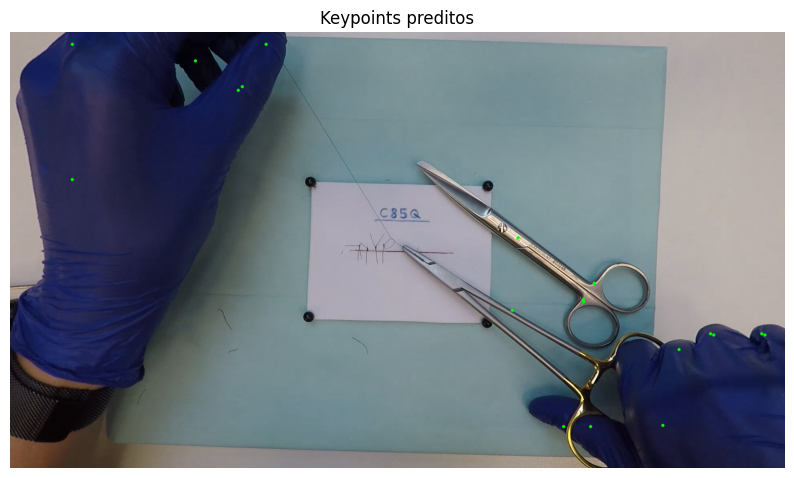

In [67]:
model.eval()
image_path = "dataset/Teste_Modelo/C85Q/frame_0004.jpg"

# Ler imagem
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_tensor = F.to_tensor(image_rgb).unsqueeze(0).to(device)

# Inferência
with torch.no_grad():
    output = model(img_tensor)[0]

# Desenhar keypoints na imagem
threshold = 0.7
for score, kpts in zip(output['scores'], output['keypoints']):
    if score < threshold:
        continue
    for x, y, v in kpts:
        if v > 0:
            cv2.circle(image_rgb, (int(x), int(y)), 4, (0, 255, 0), -1)


# print(len(output['keypoints']))
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Keypoints preditos")
plt.show()

In [37]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)


## Visualização Resultados

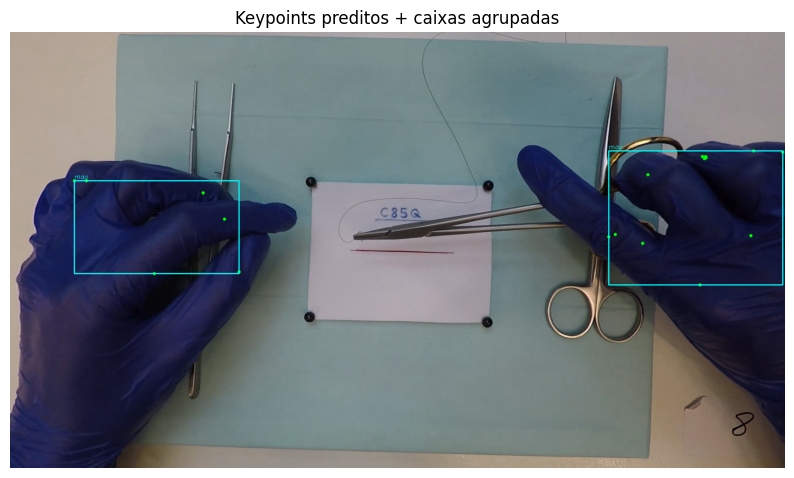

In [57]:
# 🔍 Inferência
model.eval()
image_path = "dataset/Teste_Modelo/C85Q/frame_0000.jpg"

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_tensor = F.to_tensor(image_rgb).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img_tensor)[0]

# 📦 Agrupar caixas por sobreposição
threshold = 0.7
groups = []  # cada grupo será uma lista de keypoints a fundir

for score, kpts in zip(output['scores'], output['keypoints']):
    if score < threshold:
        continue

    # Extrair keypoints visíveis
    visible = np.array([[x.item(), y.item()] for x, y, v in kpts if v > 0])
    if len(visible) == 0:
        continue

    # Criar caixa
    x_min, y_min = visible.min(axis=0)
    x_max, y_max = visible.max(axis=0)
    new_box = np.array([x_min, y_min, x_max, y_max])

    # Ver se pertence a grupo existente
    added = False
    for group in groups:
        iou = compute_iou(new_box, group["bbox"])
        if iou > 0.45:
            group["keypoints"].extend(visible.tolist())
            group["bbox"] = np.array([
                min(group["bbox"][0], x_min),
                min(group["bbox"][1], y_min),
                max(group["bbox"][2], x_max),
                max(group["bbox"][3], y_max),
            ])
            added = True
            break

    # Se não pertence a nenhum grupo, criar novo
    if not added:
        groups.append({
            "bbox": new_box,
            "keypoints": visible.tolist()
        })

# 🖍️ Desenhar tudo
for group in groups:
    x_min, y_min, x_max, y_max = group["bbox"].astype(int)
    
    for x, y in group["keypoints"]:
        cv2.circle(image_rgb, (int(x), int(y)), 4, (0, 255, 0), -1)
    
    cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 255), 2)
    cv2.putText(image_rgb, "mao", (x_min, y_min - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

# Mostrar resultado
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Keypoints preditos + caixas agrupadas")
plt.show()


## Exportar Resultado em Formato MOTChallenge-modified

In [72]:
def export_to_mot(model, frames_dir, output_txt_path, device):
    model.eval()
    instance_id = 0  # contador de objetos únicos

    label_to_id = {
    1: 1,  # mão
    2: 2,  # scissors
    3: 3,  # tweezers
    4: 4,  # needle
    5: 5   # needle holder
    }

    with open(output_txt_path, "w") as f_out:
        # Escreve cabeçalho
        header = ["frame_id", "object_id"]
        for i in range(1, 7): # 6 keypoints
            header += [f"x{i}", f"y{i}", f"v{i}"]
        f_out.write(",".join(header) + "\n")


        for i, frame_name in enumerate(sorted(os.listdir(frames_dir))):
            if not frame_name.endswith(".jpg"):
                continue

            # Ler e preparar imagem
            img_path = os.path.join(frames_dir, frame_name)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_tensor = F.to_tensor(img_rgb).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(img_tensor)[0]

            for score, label, keypoints in zip(output["scores"], output["labels"], output["keypoints"]):
                if score < 0.7:
                    continue

                obj_id = label_to_id.get(int(label), 99)

                row = [i, obj_id]  # frame_id, object_id

                for x, y, v in keypoints:
                    row += [round(float(x), 1), round(float(y), 1), int(v)]

                f_out.write(",".join(map(str, row)) + "\n")
                instance_id += 1


In [73]:
export_to_mot(
    model=model,
    frames_dir="frames2/C85Q",  # pasta com os frames
    output_txt_path="resultados_mot/task3_predictions.txt",
    device=device
)
